In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Krylov as K

In this notebook we discuss the Lanczos procedure for a symmetric matrix $H$. Starting from $H$ and given an arbitrary vector $u_0$ we build the Krylov space and compute the tridiagonal symmetric matrix $T$ that represents the $H$ matrix expressed in the Krilov base. Then we compute the diagonal matrix element of the resolvent of $H$ on $u_{0}$.

We start by building an arbitrary symmetric matrix and a normalized column vector

In [2]:
n=50
M=np.matrix(np.random.rand(n*n).reshape(n,n))
H = M + M.T
u0 = np.matrix(np.random.rand(n).reshape(n,1))
u0norm = K.norm(u0)
u0=u0/u0norm
K.norm(u0)

1.0

Now we compute the resolvent of $H$ on $u_{0}$ by using the standard spectral representation of $H$
$$ G(z) = \langle u_{0} | \frac{1}{z-H} | u_{0} \rangle = \sum_{v=1}^{n} \frac{ \langle u_{0} | v \rangle \langle v | u_{0} \rangle }{z-E_v}
$$
where $|v \rangle$ are the eigenvectors of H.

In [3]:
e,w = np.linalg.eigh(H)
K.validate_eigensystem(H,e,w)

Validation terminated


In [20]:
print(e)

[ -5.35852506e+00  -5.13021949e+00  -4.72951873e+00  -4.44442277e+00
  -4.35277568e+00  -3.95084028e+00  -3.66826649e+00  -3.49262477e+00
  -3.16590728e+00  -3.01424648e+00  -2.91661792e+00  -2.61079410e+00
  -2.53141242e+00  -2.22913340e+00  -2.08543514e+00  -1.96322501e+00
  -1.73359308e+00  -1.41707704e+00  -1.09212086e+00  -9.04325470e-01
  -7.61509348e-01  -5.03873327e-01  -3.72519388e-01  -1.67513242e-01
  -1.11252697e-02   7.78137638e-02   4.37748087e-01   5.66004502e-01
   7.21277117e-01   7.55569356e-01   9.81310649e-01   1.13489777e+00
   1.18804965e+00   1.46914311e+00   1.60898434e+00   1.91885836e+00
   2.04726177e+00   2.43755009e+00   2.72591183e+00   2.81043623e+00
   2.98183460e+00   3.15179516e+00   3.25416823e+00   3.55431218e+00
   3.76191404e+00   4.38448359e+00   4.46235602e+00   5.10885457e+00
   5.22749515e+00   4.99208404e+01]


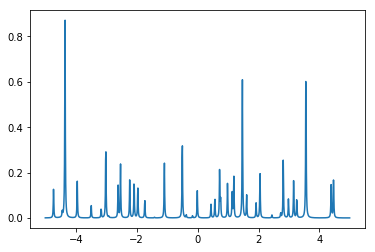

In [4]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,K.resolvent(u0,e,w,x))

Now we want to reproduce this result using the Lanczos procedure. We build the Krylov space $|\phi_{j}\rangle$ generated by the repeated action of $H$ on the given (normalized) right vector $|u_{0}\rangle$. We use the procedure described in the paper of Gruning. 

The procedure takes as input the values of $|\phi_{j}\rangle,|\phi_{j-1}\rangle,\alpha_{j},\beta_{j}$ and gives $|\phi_{j+1}\rangle,\alpha_{j+1},\beta_{j+1}$ built by the following operations:

$$
|\tilde\phi_{j+1}\rangle = (H-\alpha_{j})|\phi_{j}\rangle - \beta_{j}|\phi_{j-1}\rangle
$$

$$
\beta_{j+1} = || \tilde\phi_{j+1} || \; , \quad
|\phi_{j+1}\rangle = \frac{|\tilde\phi_{j+1}\rangle}{\beta_{j+1}} \; , \quad
\alpha_{j+1} = \langle\phi_{j+1}|H|\phi_{j+1}\rangle
$$

The procedure is initialized as follows:

$$
|\phi_{0}\rangle = |u_{0}\rangle  \; , \quad \alpha_{0} = \langle u_{0}|H|u_{0}\rangle \; , \quad \beta_{0} = 0
$$

We perform the recursion until the Krylov space reaches a given dimension

In [44]:
def GramSchimdt(vet,space,dim):
    out = vet
    for i in range(dim):
        out = out - K.sp(space[:,i],out)*space[:,i]
    return out

def lanc_recursion(H,krylov,alpha,beta,j):
    """
    j is the actual dimension of the Krylov space    
    """
    k = krylov
    a = alpha
    b = beta
    phihatjp1 = H.dot(k[:,j-1])-a[-1]*k[:,j-1]-b[-1]*k[:,j-2]
    #phihatjp1 = GramSchimdt(phihatjp1,k,j-1) 
    betajp1 = K.norm(phihatjp1)
    k[:,j] = phihatjp1/betajp1
    alphajp1 = K.sp(k[:,j],H.dot(k[:,j]))
    a.append(alphajp1)
    b.append(betajp1)
    dimVal = j+1
    return k,a,b,dimVal

In [45]:
class KrylovLoop():
    def __init__(self,dimKrylov,H,phi0,norm_=K.norm,recursion_=lanc_recursion):
        
        # definition and init
        self.dimKrylov=dimKrylov
        self.H=H
        self.alpha=[]
        self.beta=[]
        n,n1=self.H.shape
        assert n == n1
        self.recursion=recursion_
        self.krylov = np.matrix(np.zeros(n*dimKrylov).reshape(n,dimKrylov))
        
        self.krylov[:,0] = phi0
        alpha0 = K.sp(phi0,H.dot(phi0))
        self.alpha.append(alpha0)
        self.beta.append(0)
        self.dimVal = 1

        # first iteration
        self.__iterate()
        
    def __iterate(self):#,phi_j,phi_jm1):
        self.krylov,self.alpha,self.beta,self.dimVal = self.recursion(self.H,self.krylov,self.alpha,self.beta,self.dimVal) 
        
    def iterate(self,niter=None):
        # generic iteration
        nit=niter if niter is not None else self.dimKrylov
        while self.dimVal < nit :
            self.__iterate()
            print('Dimension Krylov space = ',self.dimVal,'Orthogonality check = ',K.ortCheck(self.krylov.H,self.krylov,self.dimVal),'Tridiagonal check = ',K.tridiagCheck(self.H,self.krylov.H,self.krylov,self.alpha,self.beta,self.beta,self.dimVal))

In [46]:
#reload(K)
dimKrylov = n+10
KL=KrylovLoop(dimKrylov,H,u0)
KL.iterate()

Dimension Krylov space =  3 Orthogonality check =  True Tridiagonal check =  True
Dimension Krylov space =  4 Orthogonality check =  True Tridiagonal check =  True
Dimension Krylov space =  5 Orthogonality check =  True Tridiagonal check =  True
Dimension Krylov space =  6 Orthogonality check =  True Tridiagonal check =  False
Dimension Krylov space =  7 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  8 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  9 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  10 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  11 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  12 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  13 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  14 Orthogonality check =  False Tridiagonal check =  

We compute $G(z)$ as a continued fraction:

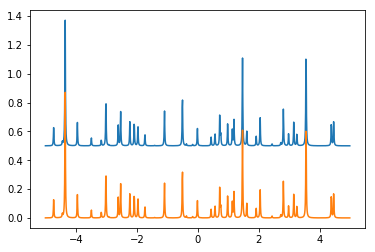

In [47]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,0.5+K.resolvent(u0,e,w,x))
plt.plot(x,K.Gfrac(KL.alpha,KL.beta,KL.beta,x))
plt.show()

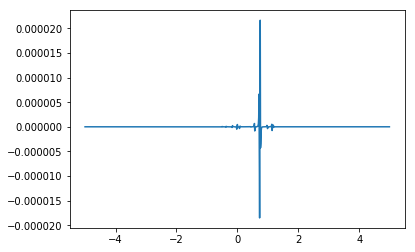

In [48]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,K.resolvent(u0,e,w,x)-K.Gfrac(KL.alpha,KL.beta,KL.beta,x))
plt.show()

In [49]:

T = K.Tmatrix(KL.alpha,KL.beta,KL.beta,dimKrylov)
eT,wT = np.linalg.eigh(T)
#print(e)
#print(eT)

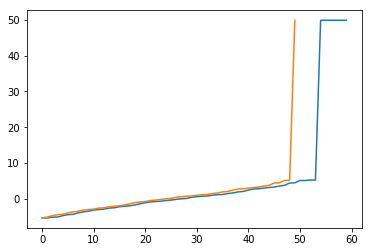

In [50]:
#plt.xlim([-4,4])
plt.plot(eT)
plt.plot(e)
plt.show()